# Compare sea level timeseries from offshore altimetry with in-situ measurements from tide gauges

**Datasets this notebook expects to find** under the below given datapaths:
- OpenADB ALES retracked altimetry data (https://openadb.dgfi.tum.de/en/data_access/#) for all available missions between 15.01.2002 and 12.04.2020 in the area of interest (4.0 / 7.0 / 52.8 / 55.5) in single .nc-files (or one combined file 'data_alt.nc' created from this notebook cell 2.1).
- A .geojson-file `mask_waddensea.geojson` with a polygon over the Wadden Sea used as a mask to make sure that only North Sea data is used.
- A .csv-file `TG_rijkswaterstaat_1992_01_01-2021_12_31.csv` (output of function 'prepare_TG_rijkswaterstaat_data' from 'CD_data_preparation.py' in the coastal_data module)
- A .nc-file `ib_correction_era5_1992-2021.nc` (output of notebook 'IB_correction.ipynb')
- A .nc-file `dac_terschelling.nc` (output of DAC_Terschelling.ipynb)
- A .csv-file `ttide_from_5years.csv` (output of ttide.ipynb)
- A .csv-file `tidal_correction_10minutes.csv` (output of tidal_correction_EOT_FES.ipynb)
- A .txt-file `psmsl_monthly_RLR_TERS.txt` (SSH RLR data from https://psmsl.org/data/obtaining/stations/236)

This notebook **saves** a file `altimetry_terschelling_extraced.csv` to the folder specified in `datapath_altimetry`.

In [1]:
# Fill in your own datapaths
datapath_altimetry = '/media/bene/Seagate/PhD-data/2_altimetry/4_OpenADB_Ters/'
datapath_mask_waddensea = '/media/bene/Seagate/PhD-data/9_masks/'
datapath_northsea_tg = '/media/bene/Seagate/PhD-data/6_tide_gauge/2_Ters-North_Sea_rijkswaterstaat/'
datapath_ib = '/media/bene/Seagate/PhD-data/11_IB_DAC/'
datapath_dac = '/media/bene/Seagate/PhD-data/11_IB_DAC/DAC/'
datapath_gnss = '/media/bene/Seagate/PhD-data/5_GNSS/'
datapath_ttide = '/media/bene/Seagate/PhD-data/3_ocean_tide_models/4_ttide/'
datapath_eot_fes = '/media/bene/Seagate/PhD-data/3_ocean_tide_models/'
datapath_psmsl = '/media/bene/Seagate/PhD-data/6_tide_gauge/1_TERS_PSMSL/'

In [2]:
# resolution of plots
dpi = 150

Other parameters that can be changed in this notebook:
- Which altimetry missions to use (2.2)
- Which GNSS-solution to use (3.1.3) (3 versions differing in how many discontinuities are removed)
- Use IB correction or DAC (3.3)
- Size of the cells used for binning the altimetry observations for timeseries building (4.)

## 0. Imports, Helper functions

In [3]:
%load_ext autoreload
%autoreload 2

import os
import pdb

import xarray as xr
import pandas as pd
import numpy as np
import statistics
from scipy import signal, stats

import geopandas as gpd
import geojson
from shapely.geometry import Point, Polygon

import matplotlib.pyplot as plt

from cartopy.feature import LAND
import cartopy.crs as ccrs

from coastal_data import CD_statistics, CD_helper_functions

In [4]:
# matplotlib fontsizes
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

In [5]:
def three_sigma_outlier_rejection(ts):
    std = CD_statistics.std(ts)
    sigma3 = 3*std
    ts_red = ts[np.abs(ts) <= sigma3]
    return ts_red

In [6]:
def remove_season_and_trend(ts):
# remove trend and seasonal signal
    f = 1 # frequency [years]
    l = ts.dropna()
    t = l.index.year + (l.index.dayofyear - 1)/365.25
    amplitude, phase, trend, offset = CD_statistics.compute_periodic_signal_and_trend(t, l, f)
    model = amplitude * np.sin(2*np.pi*f * t + phase) + trend*t + offset
    l_corr = l - model
    return l_corr

In [7]:
def interpolate_tg_to_alt(alt_index, tg_index, tg_data):
    tg_at_alt_time_interp = np.interp(alt_index, tg_index, tg_data)
    tg_at_alt_time = pd.Series(tg_at_alt_time_interp).set_axis(alt_index)
    return tg_at_alt_time

## 2. Get OpenADB ALES-retracked altimetry data

### 2.1 Basic dataset preprocessing
- Put all single .nc-files together
- Rename variables so that they can be accessed in a DataArray
- Convert times
- Add some extra information as mission name, cycle number and pass number

In [8]:
if not os.path.isfile(datapath_altimetry + 'data_alt.nc'):
    data_alt = xr.Dataset()
    # this loop takes quite a long time (~ 15 minutes on my laptop)
    for root, dirs, files in os.walk(datapath_altimetry):
        
        for fname in files:
            if fname.endswith('.nc'):
                data_temp = xr.open_dataset(os.path.join(root, fname))

                # Rename all variables to contain only the characters before the dot
                varnames = {}
                for varname_old in data_temp.keys():
                    varname_new = varname_old[0 : varname_old.find('.')]
                    varnames[varname_old] = varname_new
                data_temp = data_temp.rename(varnames)

                # Convert Julian days to datetime
                data_temp.jday.attrs['units'] = "days since 2000-01-01  12:00:00 UTC"
                data_temp = xr.decode_cf(data_temp)
                data_temp['time'] = data_temp['jday'].to_index()

                # add cycle and pass as variables
                data_temp['cycle_number'] = xr.full_like(data_temp.glon, data_temp.cycle, dtype=int) # not the best solution, copies also the attributes
                data_temp['pass_number'] = xr.full_like(data_temp.glon, data_temp.pass_number, dtype=int)

                # add missione name as variable
                data_temp['mission'] = xr.full_like(data_temp.glon, data_temp.long_mission, dtype='U25')

                # Merge everything into one dataset
                data_alt = data_alt.merge(data_temp)

    data_alt.to_netcdf(datapath_altimetry + 'data_alt.nc')
else:
    data_alt = xr.open_dataset(datapath_altimetry + 'data_alt.nc')

### 2.2 Select altimetry missions to use

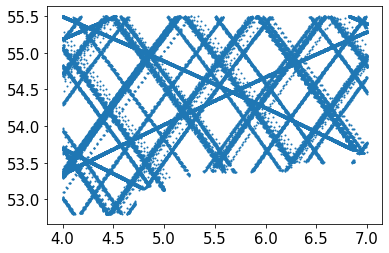

In [9]:
missions = [
            'Envisat (Version 3)', # 21.06.2002 - 11.10.2010
            'Jason-1',             # 15.01.2002 - 14.01.2009
            # 'Jason-1 (EM)',      # 10.02.2009 - 02.03.2012
            # 'Jason-1 (GM)',      # 11.05.2012 - 17.06.2013
            'Jason-2',             # 12.07.2008 - 30.09.2016
            # 'Jason-2 (EM)',      # 15.10.2016 - 17.05.2017
            'Jason-3',             # 18.02.2016 - 20.04.2019
            'Saral',               # 17.03.2013 - 28.06.2016
            # 'Saral (DP)',        # 05.07.2016 - 14.04.2019
            'Sentinel-3A',         # 24.11.2017 - 04.04.2020
            'Sentinel-3B',         # 26.11.2018 - 12.04.2020
           ]
idx = np.empty((0), dtype='int')
for mission in missions:
    idx_temp = np.where(data_alt.mission == mission)[0]
    idx = np.concatenate((idx, idx_temp))
data_mis = data_alt.isel({'time':idx})
data_mis = data_mis.sortby('time')

plt.scatter(data_mis.glon, data_mis.glat, s=1)

### 2.3 Clean and reformat to GeoDataFrame
Cleaning according to the instructions on the [OpenADB website](https://openadb.dgfi.tum.de/en/products/adaptive-leading-edge-subwaveform-retracker/)

In [10]:
alt_df = data_mis.to_dataframe().reset_index()
alt_df = alt_df[(alt_df['distance'] >= 3) | (np.isnan(alt_df['distance']))]
alt_df = alt_df[abs(alt_df['ssh'] - alt_df['mssh']) <= 2.5]
alt_df = alt_df[(alt_df['swh'] <= 11) | (np.isnan(alt_df['swh']))]
alt_df = alt_df[(alt_df['stdalt'] <= 0.2) | np.isnan(alt_df['stdalt'])]

alt_gdf = gpd.GeoDataFrame({
                           'sla[m]':alt_df.ssh - alt_df.mssh,\
                           'dist2coast[km]':alt_df.distance
                            },
                       geometry = gpd.points_from_xy(alt_df.glon, alt_df.glat))
alt_gdf = alt_gdf.set_index(pd.to_datetime(alt_df['time'], utc=True))
alt_gdf = alt_gdf.set_crs('EPSG:4326')
alt_gdf = alt_gdf.to_crs('EPSG:32631')

### 2.4 Filter out the points in the WaddenSea

In [11]:
fn = 'mask_waddensea.geojson'
with open(datapath_mask_waddensea + fn) as f:
    poly = geojson.load(f)
poly['features'][0]['geometry']['coordinates'][0]
mask_waddensea = Polygon(poly['features'][0]['geometry']['coordinates'][0])

alt_gdf = alt_gdf[~alt_gdf.intersects(mask_waddensea)]

## 3. Correct tide gauge data

### 3.1 North Sea tide gauge

In [12]:
fn = 'TG_rijkswaterstaat_1992_01_01-2021_12_31.csv'
tg_northsea = pd.read_csv(datapath_northsea_tg + fn, index_col='datetime[utc]', parse_dates=['datetime[utc]'])

#### 3.1.1 IB correction

In [13]:
tg_lat = 53.420034
tg_lon = 5.351231
fn = 'ib_correction_era5_1992-2021.nc'
ibcorr = xr.open_dataset(datapath_ib + fn)
tg_northsea_ibcorr = ibcorr.interp(lat=tg_lat, lon=tg_lon, method="linear")

time_tg = tg_northsea.index
time_ib = pd.to_datetime(tg_northsea_ibcorr.time, utc=True)
values_ib = tg_northsea_ibcorr.IB_correction

ib_at_tg_times = np.interp(time_tg, time_ib, values_ib)
tg_northsea['corr_ib[cm]'] = ib_at_tg_times * 100

#### 3.1.2 Dynamic Atmospheric Correction (DAC) (not used)
Not used as DAC adds unrealistic high jumps

In [14]:
fname = 'dac_terschelling.nc'
dac = xr.open_dataset(datapath_dac + fname)

time_dac = pd.to_datetime(dac.time, utc=True)
dac_at_tg_times = np.interp(time_tg, time_dac, dac.dac.values)
tg_northsea['corr_dac[cm]'] = dac_at_tg_times * 100

#### 3.1.3 VLM

In [15]:
# 3 options for ngl_adjusted1/2/3.csv:
# 1) Only the biggest jump with 9 mm removed (VLM -0.69 mm/year)
# 2) Adding the 4.5 mm jump (VLM -0.50 mm/year)
# 3) Adding the 3.8 mm jump (VLM -0.39 mm/year)
fname = 'ngl_adjusted2.csv'
gnss_data = pd.read_csv(datapath_gnss + fname, index_col='date', parse_dates=True)
gnss_data.index = pd.to_datetime(gnss_data.index, utc=True)

**a) Overlapping time period**

Interpolate the weekly GNSS values to the timestamps of the TG observations and subtract them directly.

In [16]:
# Reduce TG to the overlapping period
idx_tg_in_gnss = np.where(time_tg > gnss_data.index[0])
tg_northsea_overlap = tg_northsea.copy().iloc[idx_tg_in_gnss]
time_tg_overlap = tg_northsea_overlap.index

# interpolate gnss to TG
time_gnss = gnss_data.index
values_gnss = gnss_data['height[m]']

gnss_at_tg_time_overlap = np.interp(time_tg_overlap, time_gnss, values_gnss)
tg_northsea_overlap['corr_vlm[cm]'] = gnss_at_tg_time_overlap * 100

**b) Extrapolate GNSS to 01.01.1992 - 03.11.1996**

Estimate the seasonal signal and trend from the available GNSS data 03.11.1996 - 01.01.2022 with least squares. Use this function as VLM correction for the first four years.

In [17]:
# GNSS time in decimal years
t = CD_helper_functions.datatime_to_decimal_numbers(gnss_data.index)
# GNSS observations
l = gnss_data['height[m]']
# frequency
f = 1 # [years]

amplitude, phase, trend, offset = CD_statistics.compute_periodic_signal_and_trend(t, l, f)

In [18]:
print('Amplitude:', round(amplitude*100, 2), 'cm')
print('Phase:', round(phase, 2), '(rad),', round(phase * 180 / np.pi,2), 'deg')
print('Trend:', round(trend*100*10, 2), 'mm/year')
print('Offset:', round(offset, 2), 'm')

Amplitude: 0.23 cm
Phase: -1.4 (rad), -80.38 deg
Trend: -0.5 mm/year
Offset: 1.01 m


In [19]:
# Reduce TG to the not-overlapping period
idx = np.where(time_tg < gnss_data.index[0])
tg_northsea_noverlap = tg_northsea.copy().iloc[idx]

# decimal dates
t_tg_noverlap = tg_northsea_noverlap.index.year + (tg_northsea_noverlap.index.dayofyear - 1)/365.25

gnss_noverlap = amplitude * np.sin((2*np.pi*f) * t_tg_noverlap + phase) + trend*t_tg_noverlap + offset
tg_northsea_noverlap['corr_vlm[cm]'] = gnss_noverlap * 100

In [20]:
tg_northsea = pd.concat([tg_northsea_noverlap, tg_northsea_overlap])

#### 3.1.4 Tidal correction
##### T_Tide

In [21]:
fname = 'ttide_from_5years.csv'
# fname = 'ttide_from_1year.csv'

# From the t_tide experiments:
# fname = '1_ttide_from_5years_synth1_shallow-consts.csv'
# fname = '2_ttide_from_5years_manual-consts_synth1_shallow-consts.csv'
# fname = '3_ttide_from_5years_synth4p5_shallow-consts.csv'
# fname = '4_ttide_from_5years_synth4p5_no-shallow-consts.csv'
# fname = '5_ttide_from_5years_synth1_no-shallow-consts.csv'

ttide = pd.read_csv(datapath_ttide + fname, index_col='datetime[utc]', parse_dates=['datetime[utc]'])
tg_northsea['corr_ttide[cm]'] = ttide['corr[cm]']

In [22]:
tg_northsea['ssh_ib_vlm_ttide[cm]'] = tg_northsea['ssh[cm]'] - tg_northsea['corr_ib[cm]'] - tg_northsea['corr_vlm[cm]'] - tg_northsea['corr_ttide[cm]']
tg_northsea['ssh_dac_vlm_ttide[cm]'] = tg_northsea['ssh[cm]'] - tg_northsea['corr_dac[cm]'] - tg_northsea['corr_vlm[cm]'] - tg_northsea['corr_ttide[cm]']

##### Butterworth Filter
Apply filter after correcting for IB and VLM

In [23]:
ssh_corr_ib_vlm = tg_northsea['ssh[cm]'] - tg_northsea['corr_ib[cm]'] - tg_northsea['corr_vlm[cm]']
ssh_corr_dac_vlm = tg_northsea['ssh[cm]'] - tg_northsea['corr_dac[cm]'] - tg_northsea['corr_vlm[cm]']

# Order
N = 3
# Sampling frequency
fs = 1/(60*10)
# Critical frequency (cut-off frequency) (assuming Hz)
Wn = 1/(60*60*24*30) # 30 days
sos = signal.butter(N=N, Wn=Wn, btype='lowpass', output='sos', fs=fs)

tg_northsea['ssh_ib_vlm_filt[cm]'] = signal.sosfilt(sos, ssh_corr_ib_vlm)
tg_northsea['ssh_dac_vlm_filt[cm]'] = signal.sosfilt(sos, ssh_corr_dac_vlm)

##### EOT

In [24]:
fname = 'tidal_correction_10minutes.csv'
tides = pd.read_csv(datapath_eot_fes + fname, index_col='date', parse_dates=['date'])

In [25]:
tg_northsea['ssh_ib_vlm_eot[cm]'] = tg_northsea['ssh[cm]'] - tg_northsea['corr_ib[cm]'] - tg_northsea['corr_vlm[cm]'] - tides['corr_eot[cm]']
tg_northsea['ssh_dac_vlm_eot[cm]'] = tg_northsea['ssh[cm]'] - tg_northsea['corr_dac[cm]'] - tg_northsea['corr_vlm[cm]'] - tides['corr_eot[cm]']

##### FES

In [26]:
tg_northsea['ssh_ib_vlm_fes[cm]'] = tg_northsea['ssh[cm]'] - tg_northsea['corr_ib[cm]'] - tg_northsea['corr_vlm[cm]'] - tides['corr_fes[cm]']
tg_northsea['ssh_dac_vlm_fes[cm]'] = tg_northsea['ssh[cm]'] - tg_northsea['corr_dac[cm]'] - tg_northsea['corr_vlm[cm]'] - tides['corr_fes[cm]']

#### 3.1.5 Save

### 3.2 PSMSL tide gauge

In [27]:
fname = 'psmsl_monthly_RLR_TERS.txt'
tg_psmsl_orig = pd.read_csv(datapath_psmsl + fname, sep=';', header=None, names=['date', 'SSH_RLR[mm]'])

tg_psmsl = pd.DataFrame()
tg_psmsl['date'] = CD_helper_functions.decimal_numbers_to_datetime(tg_psmsl_orig['date'])
tg_psmsl = tg_psmsl.set_index('date')

# translate RLR to NAP (numbers from https://psmsl.org/data/obtaining/rlr.diagrams/236.php)
tg_psmsl['SSH_NAP[cm]'] = 0

idx = np.nonzero(tg_psmsl.index.year < 2005)[0]
tg_psmsl['SSH_NAP[cm]'][idx] = (tg_psmsl_orig['SSH_RLR[mm]'][idx] - 6936) / 10

idx = np.nonzero(tg_psmsl.index.year >= 2005)[0]
tg_psmsl['SSH_NAP[cm]'][idx] = (tg_psmsl_orig['SSH_RLR[mm]'][idx] - 6957) / 10

# reduce to 15.01.1992 - 17.12.2021
idx = np.nonzero(tg_psmsl.index.year >= 1992)[0]
tg_psmsl = tg_psmsl.iloc[idx]

#### 3.2.1 IB correction

In [28]:
psmsl_lat = 53.363
psmsl_lon = 5.220

psmsl_ibcorr = ibcorr.interp(lat=psmsl_lat, lon=psmsl_lon, method="linear")
time_psmsl = tg_psmsl.index

ib_at_psmsl_times = np.interp(time_psmsl, time_ib, values_ib)

tg_psmsl['corr_ib[cm]'] = ib_at_psmsl_times * 100

#### 3.2.2 VLM

In [29]:
# overlapping period: interpolate GNSS to psmsl times
tg_psmsl_overlap = tg_psmsl[tg_psmsl.index > gnss_data.index[0]].copy()
gnss_overlap = np.interp(tg_psmsl_overlap.index, time_gnss, values_gnss)
tg_psmsl_overlap['corr_vlm[cm]'] = gnss_overlap * 100

tg_psmsl_noverlap = tg_psmsl[tg_psmsl.index < gnss_data.index[0]].copy()
t_psmsl_noverlap = tg_psmsl_noverlap.index.year + (tg_psmsl_noverlap.index.dayofyear - 1)/365.25
gnss_noverlap = amplitude * np.sin((2*np.pi*f) * t_psmsl_noverlap + phase) + trend*t_psmsl_noverlap + offset
tg_psmsl_noverlap['corr_vlm[cm]'] = gnss_noverlap * 100

tg_psmsl = pd.concat([tg_psmsl_noverlap, tg_psmsl_overlap])

#### 3.2.3 Apply and save

In [30]:
# apply correction
tg_psmsl['ssh_ib_vlm'] = tg_psmsl['SSH_NAP[cm]'] - tg_psmsl['corr_ib[cm]'] - tg_psmsl['corr_vlm[cm]']

### 3.3 Remove outlier, trend and seasonal signal

In [31]:
# choose between IB or DAC correction
ib_or_dac = 'ib'

In [32]:
# 3-sigma outlier rejection
tg_northsea['ssh_'+ ib_or_dac +'_vlm_ttide_red[cm]'] = three_sigma_outlier_rejection(tg_northsea['ssh_'+ ib_or_dac +'_vlm_ttide[cm]'])
tg_northsea['ssh_'+ ib_or_dac +'_vlm_filt_red[cm]'] = three_sigma_outlier_rejection(tg_northsea['ssh_'+ ib_or_dac +'_vlm_filt[cm]'])
tg_northsea['ssh_'+ ib_or_dac +'_vlm_eot_red[cm]'] = three_sigma_outlier_rejection(tg_northsea['ssh_'+ ib_or_dac +'_vlm_eot[cm]'])
tg_northsea['ssh_'+ ib_or_dac +'_vlm_fes_red[cm]'] = three_sigma_outlier_rejection(tg_northsea['ssh_'+ ib_or_dac +'_vlm_fes[cm]'])

### 3.4 Tide gauge trends

In [33]:
# North Sea tide gauge
x = CD_helper_functions.datatime_to_decimal_numbers(tg_northsea.index)
trend_ttide = CD_statistics.compute_trend(x, tg_northsea['ssh_'+ ib_or_dac +'_vlm_ttide_red[cm]'].values*10)
print('t_tide:', trend_ttide)
trend_filt = CD_statistics.compute_trend(x, tg_northsea['ssh_'+ ib_or_dac +'_vlm_filt_red[cm]'].values*10)
print('butterworth:', trend_filt)
trend_eot = CD_statistics.compute_trend(x, tg_northsea['ssh_'+ ib_or_dac +'_vlm_eot_red[cm]'].values*10)
print('eot:', trend_eot)
trend_fes = CD_statistics.compute_trend(x, tg_northsea['ssh_'+ ib_or_dac +'_vlm_fes_red[cm]'].values*10)
print('fes:', trend_fes)

t_tide: 3.8622
butterworth: 3.9865
eot: 4.079
fes: 4.0755


In [34]:
# PSMSL tide gauge
x = CD_helper_functions.datatime_to_decimal_numbers(tg_psmsl.index)
trend_psmsl = CD_statistics.compute_trend(x, tg_psmsl['ssh_ib_vlm'].values*10)
print('PSMSL:', trend_psmsl)

PSMSL: 3.5039


### 3.5 Find dates when sea level exceeds x sigma

In [35]:
tg_ts = tg_northsea['ssh_ib_vlm_eot[cm]']
std = CD_statistics.std(tg_ts)
xsigma = 6 * std

idx_10min = np.where(np.abs(tg_ts) > xsigma)[0]
display(tg_ts[idx_10min])

datetime[utc]
1993-02-21 05:20:00+00:00    177.278954
1993-02-21 05:30:00+00:00    174.085106
1993-02-21 05:50:00+00:00    187.829751
1993-02-21 06:00:00+00:00    185.779233
1994-01-28 11:50:00+00:00    174.412606
                                ...    
2014-10-22 05:20:00+00:00    178.813567
2014-10-22 05:30:00+00:00    177.245389
2014-10-22 05:40:00+00:00    176.082232
2014-10-22 05:50:00+00:00    175.312574
2015-01-10 20:20:00+00:00    178.903554
Name: ssh_ib_vlm_eot[cm], Length: 149, dtype: float64

In [36]:
tg_ts_daily = tg_ts.groupby(pd.Grouper(freq='D')).mean()
std = CD_statistics.std(tg_ts_daily)
xsigma = 4 * std

idx_daily = np.where(np.abs(tg_ts_daily) > xsigma)[0]
tg_ts_daily[idx_daily]

datetime[utc]
1993-01-25 00:00:00+00:00     96.329796
1993-03-02 00:00:00+00:00   -105.067827
1994-01-28 00:00:00+00:00    127.013382
1994-02-14 00:00:00+00:00   -120.635830
1994-02-15 00:00:00+00:00   -109.479580
1995-01-01 00:00:00+00:00     99.847413
1996-01-25 00:00:00+00:00   -106.058482
1996-03-12 00:00:00+00:00   -118.708788
1997-12-17 00:00:00+00:00   -106.552431
1998-10-25 00:00:00+00:00     95.143752
1998-10-28 00:00:00+00:00    103.985938
1999-02-05 00:00:00+00:00    117.318069
2003-12-21 00:00:00+00:00     99.848189
2007-11-09 00:00:00+00:00    115.839369
2008-03-01 00:00:00+00:00    125.060047
2010-11-12 00:00:00+00:00    113.868887
2012-01-05 00:00:00+00:00     98.360628
2013-03-23 00:00:00+00:00   -113.889525
2013-03-24 00:00:00+00:00    -99.062376
2013-12-06 00:00:00+00:00    139.339365
2015-01-11 00:00:00+00:00     97.671481
2016-02-02 00:00:00+00:00     97.577707
2018-03-01 00:00:00+00:00   -118.047814
2019-01-08 00:00:00+00:00     99.892765
2020-02-10 00:00:00+00:00 

## 4. Build altimetry timeseries (chessboard binning)

In [37]:
def regular_vector(data_min, data_max, spacing_desired):
    '''
    I'm going to define a regular vector where the distance between two values
    is closest to spacing desired (in [km]).
    '''
    diff = data_max - data_min

    # starting values
    dist = diff
    i = 1 # starting value for number of cells
    eps = 0.1 * spacing_desired * 1000 # [m]
    while dist > spacing_desired * 1000 + eps:
        dist = diff / i
        i = i + 1
    print('distance between two values [km]:' , dist/1000)

    vec = np.linspace(data_min, data_max, i)
    return vec

In [38]:
# x-vector
x_dist_desired = 25 # [km]
x_vec = regular_vector(alt_gdf.geometry.x.min(), alt_gdf.geometry.x.max(), x_dist_desired)

# y-vector
y_dist_desired = 25 # [km]
y_vec = regular_vector(alt_gdf.geometry.y.min(), alt_gdf.geometry.y.max(), y_dist_desired)

distance between two values [km]: 25.06336011909506
distance between two values [km]: 25.56378584067027


In [39]:
# cell centers
centers = gpd.GeoDataFrame(columns=['cell', 'center'], geometry='center')
centers = centers.set_index('cell')

# Assign a cell number to each row of the altimetry geodataframe
cell_nr = 1
for i_x in range(1, len(x_vec)):
    for i_y in range(1, len(y_vec)):
        x1 = x_vec[i_x-1]
        x2 = x_vec[i_x]
        
        y1 = y_vec[i_y-1]
        y2 = y_vec[i_y]
        
        idx = (alt_gdf.geometry.x > x1) & (alt_gdf.geometry.x < x2) \
            & (alt_gdf.geometry.y > y1) & (alt_gdf.geometry.y < y2)
        
        alt_gdf.loc[idx, 'cell'] = int(cell_nr)
        centers.loc[cell_nr] = Point((x1+x2)/2, (y1+y2)/2)
        
        cell_nr = cell_nr + 1

In [40]:
# distance to cell centers (used for inverse distance weighting)
dist = np.zeros(len(alt_gdf))
for i in range(0, len(alt_gdf)):
    cell_nr = alt_gdf.cell[i]
    if np.isnan(cell_nr):
        dist[i] = np.nan
        continue
    dist[i] = alt_gdf.geometry[i].distance(centers.loc[cell_nr].center)

alt_gdf['dist2center[m]'] = dist

## 5. Compute correlation, RMSE & trend

In [41]:
temp_average = 'M' # period over which to average in pd.Grouper

In [42]:
def compute_RMSE(sla, tg):
    sla_red = sla - np.nanmean(sla)
    tg_red = tg - np.nanmean(tg)
    rmse = np.sqrt(((sla_red - tg_red) **2).sum()/(len(sla_red)-1))    
    return rmse

In [229]:
def fill_cell_stats(tg_data, col_descr, df_monthly_av):
    # bring tide gauge data to the same time stamps
    tg_at_alt_time = interpolate_tg_to_alt(df_red.index, tg_data.index, tg_data)
    tg_mon = tg_at_alt_time.groupby(pd.Grouper(freq=temp_average)).mean()
    # remove values in tg_mon where month/year combination is not in df_monthly_av
    tg_mon = tg_mon.loc[tg_mon.index.isin(df_monthly_av.index)]
    
    # remove rows that contain NaN in tg_mon
    idx = np.where(np.isnan(tg_mon))[0]
    tg_mon = tg_mon.drop(tg_mon.index[idx])
    df_monthly_av = df_monthly_av.drop(tg_mon.index[idx])
    
    # correlation
    col_R = 'R_' + col_descr
    # Version 1: pandas Pearson correlation
    # cell_stats.loc[cell, (col_R)] = df_monthly_av['monthly_av'].corr(tg_mon)
    
    # Version 2: scipy Pearson correlation with p-value
    col_p = 'p_' + col_descr
    R_temp, p_temp = stats.pearsonr(df_monthly_av['monthly_av'].values, tg_mon.values)
    cell_stats.loc[cell, (col_R)] = R_temp
    cell_stats.loc[cell, (col_p)] = p_temp
    
    # RMSE
    col_RMSE = 'RMSE_' + col_descr    
    cell_stats.loc[cell, (col_RMSE)] = compute_RMSE(df_monthly_av['monthly_av'], tg_mon/100)

In [234]:
psmsl = tg_psmsl['ssh_ib_vlm'] # tg_psmsl['SSH_NAP[cm]'] # tg_psmsl['SSH_NAP[cm]'] - tg_psmsl['corr_vlm[cm]']
tg_filt = tg_northsea['ssh_'+ ib_or_dac +'_vlm_filt_red[cm]']
tg_eot = tg_northsea['ssh_'+ ib_or_dac +'_vlm_eot_red[cm]']
tg_fes = tg_northsea['ssh_'+ ib_or_dac +'_vlm_fes_red[cm]']
tg_ttide = tg_northsea['ssh_'+ ib_or_dac +'_vlm_ttide_red[cm]']

cell_numbers = np.sort((alt_gdf['cell'].dropna().unique()))
cell_stats = pd.DataFrame(np.nan, index=pd.Index(cell_numbers, name='cell'),\
                            columns=['date_min', 'date_max', 'number_values(months)', 'R_psmsl', 'p_psmsl', \
                           'RMSE_psmsl', 'R_filt', 'RMSE_filt', 'R_eot', 'RMSE_eot', 'R_fes', \
                           'RMSE_fes', 'R_ttide', 'RMSE_ttide', 'alt_trend'])

for cell, df in alt_gdf.groupby('cell'):
    # 1. Altimetry timeseries
    df_red = df.copy()
    df_red['sla_red[m]'] = three_sigma_outlier_rejection(df['sla[m]'])
    # df_red_des_det = remove_season_and_trend(df_red)
    
    # monthly averages weighted with inverse distance to cell
    df_monthly_av = pd.DataFrame(columns=['time', 'monthly_av'], dtype='float64').set_index('time')
    for time, df_month in df_red.groupby(pd.Grouper(freq=temp_average)):
        if len(df_month) > 0:
            weights = 1/df_month['dist2center[m]']
            monthly_av = (df_month['sla_red[m]'] * weights).sum()/weights.sum()
        else:
            continue
        df_monthly_av_temp = pd.DataFrame({'monthly_av':monthly_av}, index=[time])
        df_monthly_av = pd.concat([df_monthly_av, df_monthly_av_temp])
    
    fill_cell_stats(psmsl, 'psmsl', df_monthly_av)
    fill_cell_stats(tg_filt, 'filt', df_monthly_av)
    fill_cell_stats(tg_eot, 'eot', df_monthly_av)
    fill_cell_stats(tg_fes, 'fes', df_monthly_av)
    fill_cell_stats(tg_ttide, 'ttide', df_monthly_av)
    
    # trends
    x = CD_helper_functions.datatime_to_decimal_numbers(df_monthly_av['monthly_av'].index)
    trend = CD_statistics.compute_trend(x, df_monthly_av['monthly_av'].values*1000) # [mm/year]
    cell_stats.loc[cell, ('alt_trend')] = trend
    cell_stats.loc[cell, ('date_min')] = df_monthly_av.index.min()
    cell_stats.loc[cell, ('date_max')] = df_monthly_av.index.max()
    cell_stats.loc[cell, ('number_values(months)')] = len(df_monthly_av.index)

<AxesSubplot:xlabel='cell'>

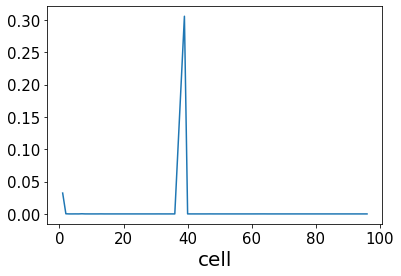

In [239]:
cell_stats['p_psmsl'].plot()

In [45]:
# trend differences
trend_diff_psmsl = cell_stats['alt_trend'] - trend_psmsl
trend_diff_eot = cell_stats['alt_trend'] - trend_eot
trend_diff_filt = cell_stats['alt_trend'] - trend_filt
trend_diff_ttide = cell_stats['alt_trend'] - trend_ttide

## 6. Plots

### 6.1 Histograms

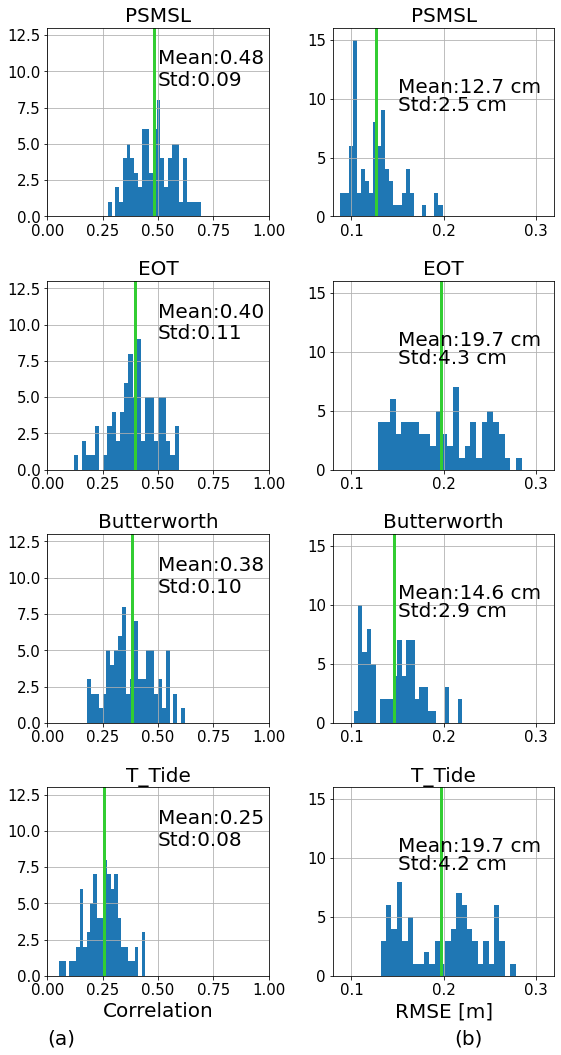

In [237]:
def plot_hist_corr(nr, chess_corr_data, title=''):
    axs[nr].hist(chess_corr_data, bins=25)
    axs[nr].set_title(title)
    axs[nr].text(0.5,10.5,'Mean:'+str("%.2f" % round(statistics.fmean(chess_corr_data),2)))
    axs[nr].text(0.5,9.0,'Std:'+str("%.2f" % round(statistics.stdev(chess_corr_data),2)))
    axs[nr].axvline(statistics.fmean(chess_corr_data), c='limegreen', linewidth=3)
    axs[nr].set_xlim(0,1)
    axs[nr].set_ylim(0,13)
    axs[nr].grid()
def plot_hist_rmse(nr, chess_corr_data, title=''):
    axs[nr].hist(chess_corr_data, bins=25)
    axs[nr].set_title(title)
    axs[nr].text(0.15,10.5,'Mean:'+str("%.1f" % round(statistics.fmean(chess_corr_data)*100,2))+' cm')
    axs[nr].text(0.15,9.0,'Std:'+str("%.1f" % round(statistics.stdev(chess_corr_data)*100,2))+' cm')
    axs[nr].axvline(statistics.fmean(chess_corr_data), c='limegreen', linewidth=3)
    axs[nr].set_xlim(0.08,0.32)
    axs[nr].set_ylim(0,16)
    axs[nr].grid()
    
fig, axs = plt.subplots(4,2,figsize=(8,15))
plot_hist_corr((0,0), cell_stats['R_psmsl'], title='PSMSL')
plot_hist_corr((1,0), cell_stats['R_eot'], title='EOT')
plot_hist_corr((2,0), cell_stats['R_filt'], title='Butterworth')
plot_hist_corr((3,0), cell_stats['R_ttide'], title='T_Tide')
plot_hist_rmse((0,1), cell_stats['RMSE_psmsl'], title='PSMSL')
plot_hist_rmse((1,1), cell_stats['RMSE_eot'], title='EOT')
plot_hist_rmse((2,1), cell_stats['RMSE_filt'], title='Butterworth')
plot_hist_rmse((3,1), cell_stats['RMSE_ttide'], title='T_Tide')

axs[3,0].set_xlabel('Correlation')
axs[3,0].text(0, -.36, '(a)', transform=axs[3,0].transAxes)
axs[3,1].set_xlabel('RMSE [m]')
axs[3,1].text(.55, -.36, '(b)', transform=axs[3,1].transAxes)
fig.tight_layout()
plt.savefig('../../99_plot_dump/hist_corr_rmse.png', dpi=dpi, bbox_inches='tight')


### 6.2 RMSE histograms

In [48]:
print(cell_stats['RMSE_psmsl'].min())
print(cell_stats['RMSE_psmsl'].max())

0.08806039052154928
0.1988021905509398


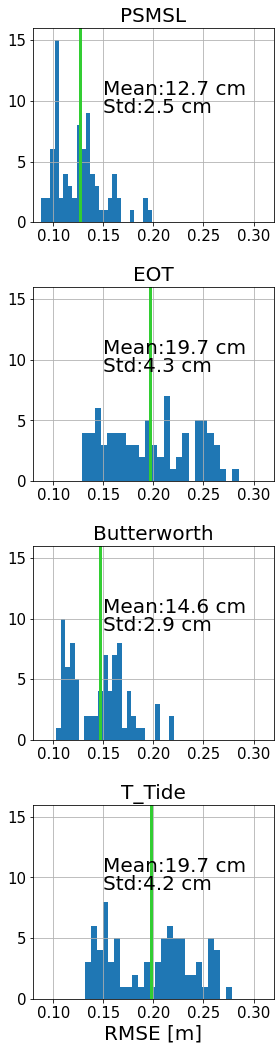

In [49]:
def plot_hist(nr, chess_corr_data, title=''):
    axs[nr].hist(chess_corr_data, bins=25)
    axs[nr].set_title(title)
    axs[nr].text(0.15,10.5,'Mean:'+str("%.1f" % round(statistics.fmean(chess_corr_data)*100,2))+' cm')
    axs[nr].text(0.15,9.0,'Std:'+str("%.1f" % round(statistics.stdev(chess_corr_data)*100,2))+' cm')
    axs[nr].axvline(statistics.fmean(chess_corr_data), c='limegreen', linewidth=3)
    axs[nr].set_xlim(0.08,0.32)
    axs[nr].set_ylim(0,16)
    # axs[nr].set_xlabel('RMSE [m]')
    axs[nr].grid()
fig, axs = plt.subplots(4,1,figsize=(4.3,15))
plot_hist(0, cell_stats['RMSE_psmsl'], title='PSMSL')
plot_hist(1, cell_stats['RMSE_eot'], title='EOT')
plot_hist(2, cell_stats['RMSE_filt'], title='Butterworth')
plot_hist(3, cell_stats['RMSE_ttide'], title='T_Tide')
axs[3].set_xlabel('RMSE [m]')
fig.tight_layout()
plt.savefig('../../99_plot_dump/hist_rmse_vertical.png', dpi=dpi, bbox_inches='tight')

### Trend difference histograms

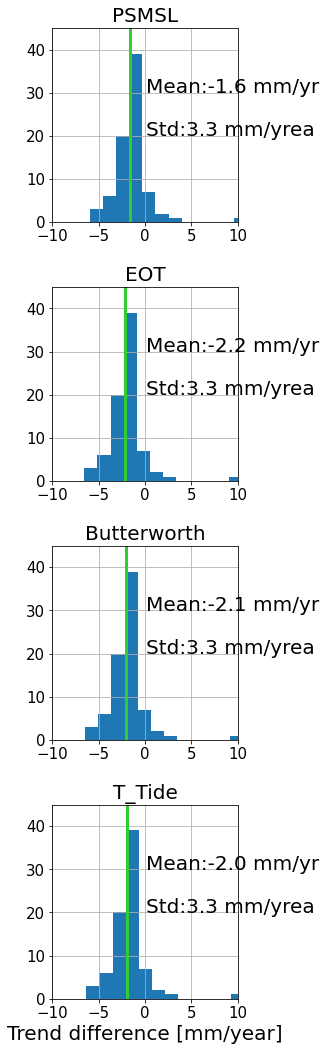

In [50]:
def plot_hist(nr, chess_corr_data, title=''):
    axs[nr].hist(chess_corr_data, bins=25)
    axs[nr].set_title(title)
    axs[nr].text(0.15,30,'Mean:'+str("%.1f" % round(statistics.fmean(chess_corr_data),2))+' mm/yr')
    axs[nr].text(0.15,20,'Std:'+str("%.1f" % round(statistics.stdev(chess_corr_data),2))+' mm/yrea')
    axs[nr].axvline(statistics.fmean(chess_corr_data), c='limegreen', linewidth=3)
    axs[nr].set_xlim(-10,10)
    axs[nr].set_ylim(0,45)
    # axs[nr].set_xlabel('RMSE [m]')
    axs[nr].grid()
fig, axs = plt.subplots(4,1,figsize=(4.3,15))
plot_hist(0, trend_diff_psmsl, title='PSMSL')
plot_hist(1, trend_diff_eot, title='EOT')
plot_hist(2, trend_diff_filt, title='Butterworth')
plot_hist(3, trend_diff_ttide, title='T_Tide')
axs[3].set_xlabel('Trend difference [mm/year]')
fig.tight_layout()
plt.savefig('../../99_plot_dump/hist_trenddiff.png', dpi=dpi, bbox_inches='tight')

### 6.3 Maps

In [51]:
cells_full = np.arange((len(y_vec)-1) * (len(x_vec)-1)) + 1
empty_cells = [_ for _ in cells_full if _ not in cell_stats.index]
empty_cells = np.asarray(empty_cells)
empty_cells_idx = empty_cells -1

def reformat_chess_data(chess_stats):
    '''
    chess_stats: List of R or RMSE
    
    Other notebook-wide variables used (make sure the respective cells were run before):
        empty_cells_idx
        x_vec, y_vec
        
    This function does 2 things:
        1. Adding nans for the cells which don't contain data
        2. Reshapes the values in a way that plotting with pcolormesh colors the right fields on the map.
    '''
    chess_stats_full = chess_stats
    for idx in empty_cells_idx:
        chess_stats_full = np.insert(chess_stats_full, idx, np.nan)

    chess_stats_full_re = np.reshape(chess_stats_full, ((len(x_vec)-1,len(y_vec)-1)))
    chess_stats_full_re = np.transpose(chess_stats_full_re)
    
    return chess_stats_full_re

In [131]:
def plot_map(ax, data, tg_psmsl_loc, vmin=None, vmax=None, cmap='Blues', title='', label=''):
    '''
    first create fig and ax like:
        fig = plt.figure(figsize=(12,12))
        ax = plt.axes(projection=ccrs.PlateCarree())
    '''
    data_re = reformat_chess_data(data)
    crs_32631 = ccrs.epsg('32631')    
    ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
    ax.add_feature(LAND, edgecolor = 'darkgray', facecolor = "lightgray", zorder=2)
    plot = ax.pcolormesh(x_vec, y_vec, data_re, transform=crs_32631, cmap=cmap, vmin = vmin, vmax = vmax)
    ax.scatter(alt_gdf.geometry.x, alt_gdf.geometry.y, marker='+', s=1, c='darkgrey', transform=crs_32631)
    ax.plot(tg_psmsl_loc.x, tg_psmsl_loc.y, 'o', color='red', markersize=10, transform=crs_32631)
    
    # mark selected cells
    # cell 95
    ax.plot([x_vec[7], x_vec[8], x_vec[8], x_vec[7], x_vec[7]], [y_vec[11], y_vec[11], y_vec[12], y_vec[12], y_vec[11]],\
            color='darkred', linewidth=5, transform=crs_32631)
    # cell 96
    ax.plot([x_vec[7], x_vec[8], x_vec[8], x_vec[7], x_vec[7]], [y_vec[10], y_vec[10], y_vec[11], y_vec[11], y_vec[10]],\
            color='darkred', linewidth=5, transform=crs_32631)

    # cell 83
    ax.plot([x_vec[6], x_vec[7], x_vec[7], x_vec[6], x_vec[6]], [y_vec[10], y_vec[10], y_vec[11], y_vec[11], y_vec[10]],\
            color='darkred', linewidth=5, transform=crs_32631)

    # cell 82
    ax.plot([x_vec[6], x_vec[7], x_vec[7], x_vec[6], x_vec[6]], [y_vec[9], y_vec[9], y_vec[10], y_vec[10], y_vec[9]],\
            color='darkred', linewidth=5, transform=crs_32631)

    # cell 70
    ax.plot([x_vec[5], x_vec[6], x_vec[6], x_vec[5], x_vec[5]], [y_vec[9], y_vec[9], y_vec[10], y_vec[10], y_vec[9]],\
            color='darkred', linewidth=5, transform=crs_32631)

    # cell 69
    ax.plot([x_vec[5], x_vec[6], x_vec[6], x_vec[5], x_vec[5]], [y_vec[8], y_vec[8], y_vec[9], y_vec[9], y_vec[8]],\
            color='darkred', linewidth=5, transform=crs_32631)

    # plot cell numbers
    for cell_nr in centers.index:
        if cell_nr in cell_stats_long.index:
            text = ax.text(centers.loc[cell_nr, 'center'].x-5000,centers.loc[cell_nr, 'center'].y-5000,str(cell_nr), fontsize=18,\
                    transform=crs_32631, bbox=dict(boxstyle="square", fill=False))
        else:
            text = ax.text(centers.loc[cell_nr, 'center'].x-5000,centers.loc[cell_nr, 'center'].y-5000,str(cell_nr), fontsize=18,\
                    transform=crs_32631)

    plt.colorbar(plot, shrink=1, label=label, ax=ax)
    ax.set_title(title);
    fig.tight_layout()

#### Number of altimetry points per cell

In [53]:
# Find the cells that cover the period between 07.2002 and 04.2020
date_begin_latest = pd.to_datetime('2002-07-01', utc=True)
date_end_earliest = pd.to_datetime('2020-03-31', utc=True)

idx_long = np.where((cell_stats['date_min'] <= date_begin_latest) & (cell_stats['date_max'] >= date_end_earliest))[0]
print('number of all cells:', len(cell_stats.index), ', number of cells with timeseries between', \
      str(date_begin_latest), 'and', str(date_end_earliest), ':', len(idx_long))

cell_stats_long = cell_stats.iloc[idx_long]
print('minimum number of monthly averaged values per cell:', cell_stats_long['number_values(months)'].min())
print('maximum number of monthly averaged values per cell:', cell_stats_long['number_values(months)'].max())

number of all cells: 80 , number of cells with timeseries between 2002-07-01 00:00:00+00:00 and 2020-03-31 00:00:00+00:00 : 54
minimum number of monthly averaged values per cell: 125.0
maximum number of monthly averaged values per cell: 220.0


In [54]:
npoints = alt_gdf.value_counts(subset='cell').sort_index()
num_obs_float = [float(_) for _ in npoints]

In [55]:
# North sea tide gauge location
tg_loc = gpd.GeoSeries(gpd.points_from_xy([tg_lon], [tg_lat]))
tg_loc = tg_loc.set_crs('EPSG:4326')
tg_loc = tg_loc.to_crs('EPSG:32631')

# PSMSL tide gauge location
psmsl_loc = gpd.GeoSeries(gpd.points_from_xy([psmsl_lon], [psmsl_lat]))
psmsl_loc = psmsl_loc.set_crs('EPSG:4326')
psmsl_loc = psmsl_loc.to_crs('EPSG:32631')

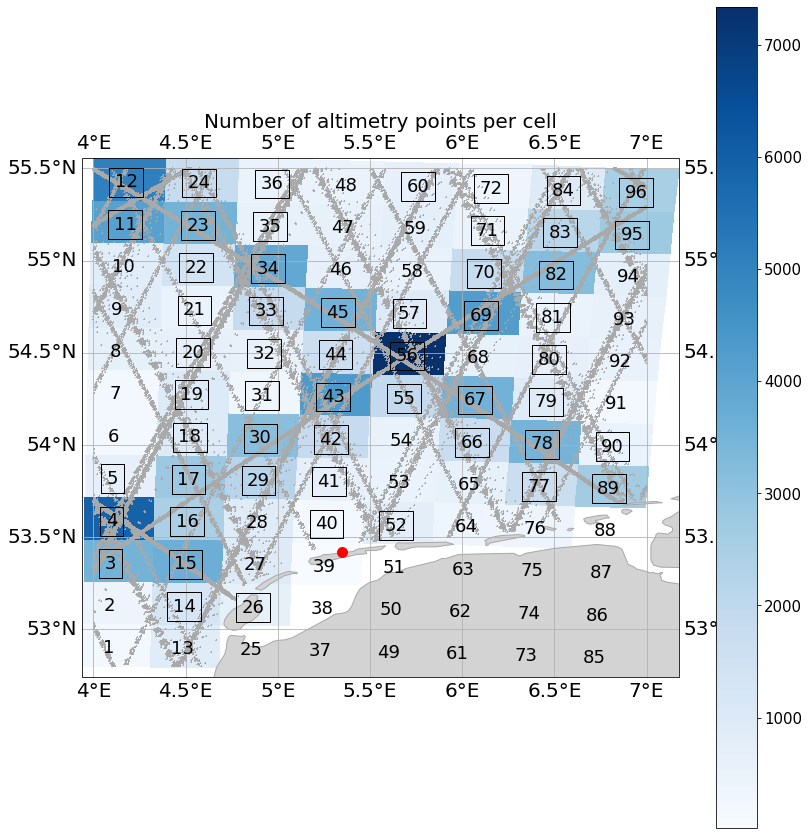

In [106]:
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
plot_map(ax, num_obs_float, tg_loc, cmap='Blues', title='Number of altimetry points per cell')

#### R, RMSE, trend

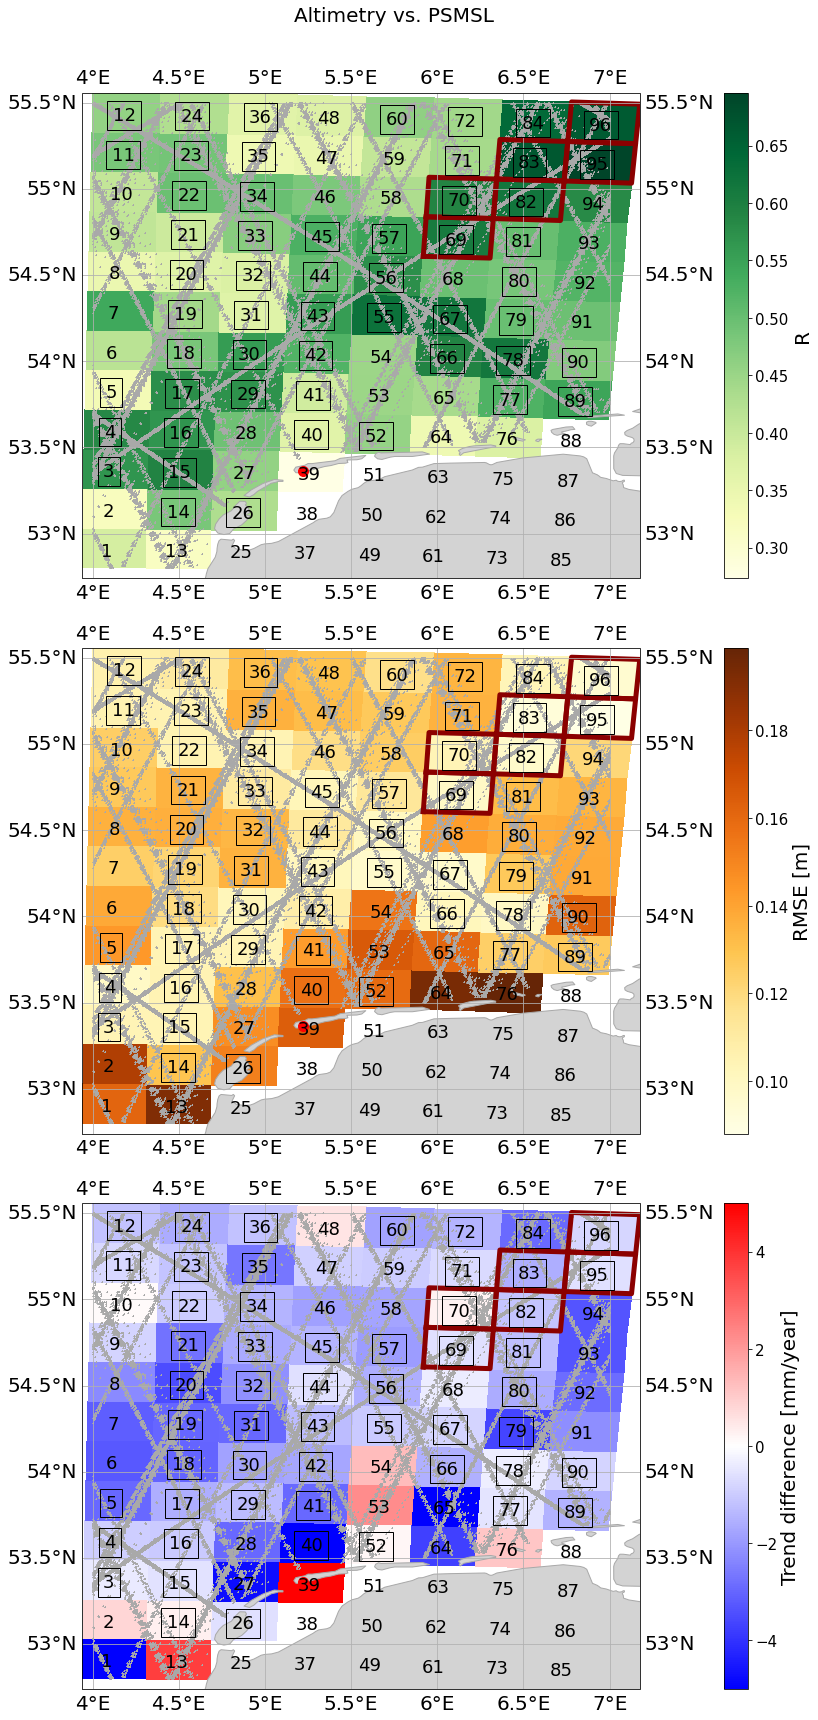

In [132]:
fig, axs = plt.subplots(3,1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(24,24))
plt.subplots_adjust(left=0.8)
fig.tight_layout()
fig.suptitle('Altimetry vs. PSMSL', x=0.65, y=1)
plot_map(axs[0], cell_stats['R_psmsl'].values, psmsl_loc, cmap='YlGn', title='', label='R')
plot_map(axs[1], cell_stats['RMSE_psmsl'].values, psmsl_loc, cmap='YlOrBr', title='', label='RMSE [m]')
plot_map(axs[2], trend_diff_psmsl.values, psmsl_loc, vmin=-5.0, vmax=5.0, cmap='bwr', title='', label='Trend difference [mm/year]')
plt.savefig('../../99_plot_dump/maps_altimetry_vs_psmsl.png', dpi=dpi, bbox_inches='tight')

## 7. Find the altimetry timeseries that best represents sea level at the coast

In [60]:
# Find cells with highest R, lowest RMSE and smallest trend difference
nr = 10 # show the x best candidates
print(cell_stats['R_psmsl'].iloc[idx_long].sort_values().iloc[-nr:])
print(cell_stats['RMSE_psmsl'].iloc[idx_long].sort_values().iloc[:nr])
print(np.abs(trend_diff_psmsl.iloc[idx_long]).sort_values().iloc[:nr])

cell
15.0    0.591491
69.0    0.605380
78.0    0.614889
67.0    0.615392
82.0    0.616715
55.0    0.623960
84.0    0.639368
96.0    0.661595
83.0    0.667718
95.0    0.696055
Name: R_psmsl, dtype: float64
cell
95.0    0.088060
83.0    0.092300
96.0    0.095288
55.0    0.096816
82.0    0.097323
67.0    0.097464
4.0     0.098782
69.0    0.098870
78.0    0.099553
56.0    0.100347
Name: RMSE_psmsl, dtype: float64
cell
52.0    0.1875
70.0    0.2622
14.0    0.2802
78.0    0.3400
3.0     0.4283
77.0    0.5308
15.0    0.5742
44.0    0.6015
95.0    0.6051
69.0    0.6064
Name: alt_trend, dtype: float64


### Extract the North East region
Cells 96, 95, 83, 82, 70, 69

In [88]:
# Select cells
alt_gdf_ex = alt_gdf.loc[(alt_gdf['cell'] == 96.0) |\
            (alt_gdf['cell'] == 95.0) |\
            (alt_gdf['cell'] == 83.0) |\
            (alt_gdf['cell'] == 82.0) |\
            (alt_gdf['cell'] == 70.0) |\
            (alt_gdf['cell'] == 69.0) \
           ]

# Reduce outliers
df_red_ex = alt_gdf_ex.copy()
df_red_ex['sla_red[m]'] = three_sigma_outlier_rejection(alt_gdf_ex['sla[m]'])

# Monthly averages weighted with inverse distance to cell
alt_ex_monthly_av = pd.DataFrame(columns=['time', 'monthly_av[cm]'], dtype='float64').set_index('time')
for time, df_month in df_red_ex.groupby(pd.Grouper(freq=temp_average)):
    weights = 1/df_month['dist2center[m]']
    monthly_av = (df_month['sla_red[m]'] * weights).sum()/weights.sum()
    alt_ex_monthly_av_temp = pd.DataFrame({'time': time, 'monthly_av[cm]':monthly_av*100}, index=[time]).set_index('time')
    alt_ex_monthly_av = pd.concat([alt_ex_monthly_av, alt_ex_monthly_av_temp])

In [89]:
fn = 'altimetry_terschelling_extraced.csv'
if not os.path.isfile(datapath_altimetry + fn):
    alt_ex_monthly_av.to_csv(datapath_altimetry + fn)

In [90]:
alt_ex_monthly_av

,monthly_av[cm]
time,
2002-01-31 00:00:00+00:00,25.649805
2002-02-28 00:00:00+00:00,26.343316
2002-03-31 00:00:00+00:00,3.618491
2002-04-30 00:00:00+00:00,1.383106
2002-05-31 00:00:00+00:00,-1.997987
...,...
2019-12-31 00:00:00+00:00,19.352823
2020-01-31 00:00:00+00:00,33.526090
2020-02-29 00:00:00+00:00,33.616288


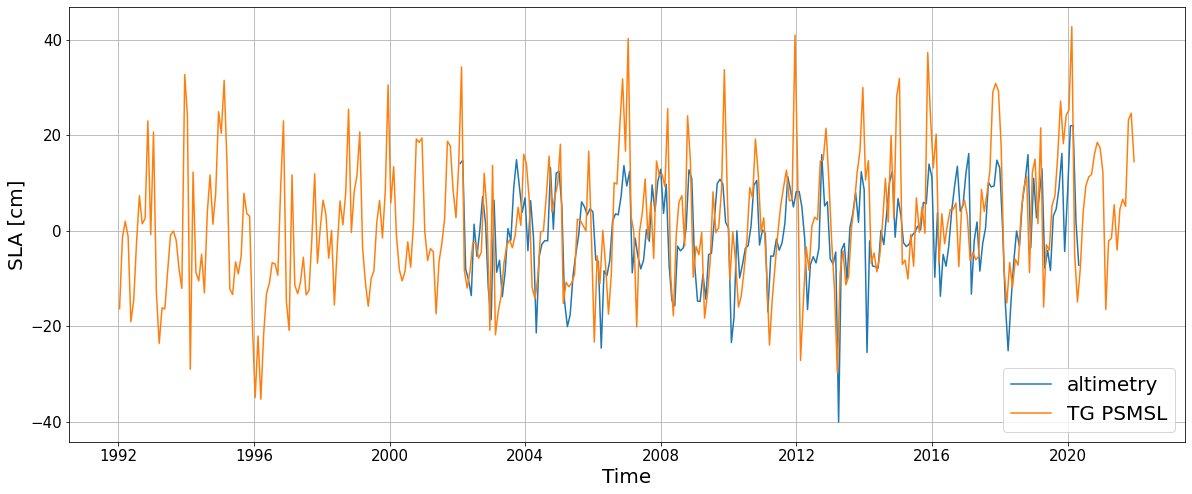

In [77]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(alt_ex_monthly_av-np.median(alt_ex_monthly_av), label='altimetry')
ax.plot(tg_psmsl['ssh_ib_vlm']-np.median(tg_psmsl['ssh_ib_vlm']), label='TG PSMSL')
ax.legend(loc='lower right')
ax.set_xlabel('Time')
ax.set_ylabel('SLA [cm]')
ax.grid()